In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import reedsolo as rs
from reedsolo import ReedSolomonError

In [2]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

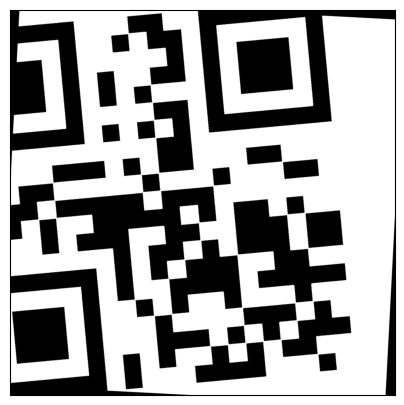

In [3]:
img = cv2.imread("02-Matsawar-3edel-ya3am.png", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
img = rotate_image(img, -3)

kernel = np.ones((3, 3), np.uint8)
dilated_img = cv2.dilate(img, kernel, iterations=1)

fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(dilated_img, cmap='gray');

(21, 21)


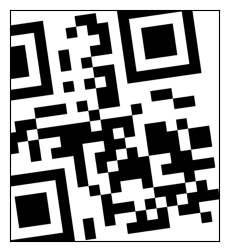

In [4]:
_, img = cv2.threshold(cv2.imread("02-Matsawar-3edel-ya3am.png", cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY);

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

img_no_quiet_zone = img[start_row:end_row, start_col:end_col]

# Alternative method to get the grid directly
# I directly resize it to 21x21 and use something like the replacement downscaling geometric transformation
# So for each collection of pixels, only one pixel survives, and since this is a perfect test case, it works
# In non-perfect test cases, you'd have needed to do some more steps to ensure correct replacement is done

img_21x21_grid = cv2.resize(img_no_quiet_zone, (21, 21), interpolation=cv2.INTER_AREA) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img_no_quiet_zone, cmap='gray');
print(img_21x21_grid.shape)

In [5]:
img_inv = 1- img_21x21_grid

In [6]:
ecl = img_inv[8, 0:2]
mask = img_inv[8, 2:5]

print(ecl, mask)

[1 1] [1 1 1]


In [7]:
# Dictionary of all masks and their equivalent formulae
# P.S. I modified them to account for that I skipped the FEC mask part above
# If you will do it, do not XOR the mask if you wish to use this MASKS table
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}
# Enum for the different directions of reading blocks in the QR code
# The number indicates how many bytes are in this block
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [8]:
# A more general apply_mask function (still works the same way)
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [9]:
enc_bits = apply_mask_general(21-1, 21-1, img_inv, mask, UP8)[:4]
print(enc_bits)

[0, 0, 1, 1]


In [10]:
len_bits = apply_mask_general(21-3, 21-1, img_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'{len_bits} = {len_int} data symbols, each consisting of 8 bits')

[1, 1, 1, 1, 1, 1, 0, 1] = 253 data symbols, each consisting of 8 bits


In [11]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [12]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
# Let me re-format this for better readability :)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
for _ in range(len(block_starting_indices)):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1



11111111 (=255) = ÿ
01001101 (=077) = M
01010101 (=085) = U
01010101 (=085) = U
10100100 (=164) = ¤
10101010 (=170) = ª
10101010 (=170) = ª
10110111 (=183) = ·
11111111 (=255) = ÿ
11111111 (=255) = ÿ
11110101 (=245) = õ
01011101 (=093) = ]
01010101 (=085) = U
01010010 (=082) = R
01010101 (=085) = U
01011110 (=094) = ^
10101010 (=170) = ª
1010 (=010) = 

10101010 (=170) = ª
10101010 (=170) = ª
10101001 (=169) = ©
11111111 (=255) = ÿ
11111111 (=255) = ÿ
01010101 (=085) = U
11101010 (=234) = ê


In [14]:
print(f"Length of block_starting_indices: {len(block_starting_indices)}")
print(f"Current byte_index: {byte_index}")

if byte_index < len(block_starting_indices):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_inv, mask, dir)
    message_bits.extend(bits)
    print(bits)
    byte_index += 1
else:
    print(f"Error: byte_index {byte_index} is out of range.")


Length of block_starting_indices: 25
Current byte_index: 25
Error: byte_index 25 is out of range.
